# Install and Import Required Packages

In [ ]:
# Install required packages
!pip install -q datasets transformers sentence-transformers gensim scikit-learn pandas nltk torch

# Import libraries
from datasets import load_dataset
import pandas as pd
import numpy as np
import re
import html
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
import time
import unicodedata

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Load Dataset & EDA

In [ ]:
# Load IMDB dataset
imdb = load_dataset("imdb")

# Print the Dataset Structure
print(imdb)

# Review Example
print(imdb['train'][0])

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})
{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and

In [ ]:
# Convert to pandas DataFrame
train_data = pd.DataFrame(imdb["train"])
test_data = pd.DataFrame(imdb["test"])

print(train_data.head())
print("\n")
print(test_data.head())

print("\n")
print("Train Split Shape:", train_data.shape)
print("Test Split Shape:", test_data.shape)

                                                text  label
0  I rented I AM CURIOUS-YELLOW from my video sto...      0
1  "I Am Curious: Yellow" is a risible and preten...      0
2  If only to avoid making this type of film in t...      0
3  This film was probably inspired by Godard's Ma...      0
4  Oh, brother...after hearing about this ridicul...      0


                                                text  label
0  I love sci-fi and am willing to put up with a ...      0
1  Worth the entertainment value of a rental, esp...      0
2  its a totally average film with a few semi-alr...      0
3  STAR RATING: ***** Saturday Night **** Friday ...      0
4  First off let me say, If you haven't enjoyed a...      0


Train Split Shape: (25000, 2)
Test Split Shape: (25000, 2)


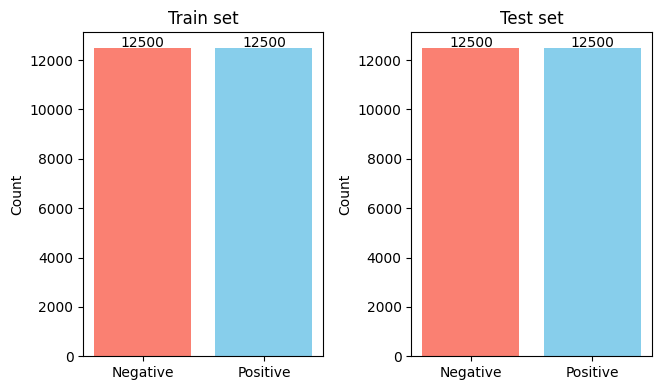

In [ ]:
# Prepare data for Plotting Distribution
datasets = {
    "Train": train_data["label"],
    "Test": test_data["label"]
}

# Plot distribution
plt.figure(figsize=(10,4))
for i, (name, labels) in enumerate(datasets.items(), 1):
    plt.subplot(1, 3, i)
    counts = labels.value_counts().sort_index()
    plt.bar(["Negative","Positive"], counts, color=["salmon","skyblue"])
    plt.title(f"{name} set")
    plt.ylabel("Count")
    for j, c in enumerate(counts):
        plt.text(j, c+50, str(c), ha="center")

plt.tight_layout()
plt.show()

# Text preprocessing

In [ ]:
# Text preprocessing
def clean_text(text):
    text = str(text)
    text = html.unescape(text)
    text = re.sub(r"<.*?>", " ", text)
    text = unicodedata.normalize("NFKC", text)
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

train_data["clean_text"] = train_data["text"].apply(clean_text)
test_data["clean_text"] = test_data["text"].apply(clean_text)

In [ ]:
print(train_data.head())
print("\n")
print(test_data.head())
print("\n")

                                                text  label  \
0  I rented I AM CURIOUS-YELLOW from my video sto...      0   
1  "I Am Curious: Yellow" is a risible and preten...      0   
2  If only to avoid making this type of film in t...      0   
3  This film was probably inspired by Godard's Ma...      0   
4  Oh, brother...after hearing about this ridicul...      0   

                                          clean_text  
0  i rented i am curious yellow from my video sto...  
1  i am curious yellow is a risible and pretentio...  
2  if only to avoid making this type of film in t...  
3  this film was probably inspired by godard s ma...  
4  oh brother after hearing about this ridiculous...  


                                                text  label  \
0  I love sci-fi and am willing to put up with a ...      0   
1  Worth the entertainment value of a rental, esp...      0   
2  its a totally average film with a few semi-alr...      0   
3  STAR RATING: ***** Saturday Night 

# Dataset Splitting

In [ ]:
# Train / Validation / Test Split

train_df, val_df = train_test_split(train_data, test_size=0.2, random_state=1, stratify=train_data["label"])
y_train, y_val, y_test = train_df["label"].values, val_df["label"].values, test_data["label"].values

print("Train Split Shape:", train_df.shape)
print("Validation Split Shape:", val_df.shape)
print("Test Split Shape:", test_data.shape)

print(y_train)
print(y_val)
print(y_test)

Train Split Shape: (20000, 3)
Validation Split Shape: (5000, 3)
Test Split Shape: (25000, 3)
[0 1 0 ... 0 1 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 1 1 1]


# TF–IDF + Logistic Regression


=== TF–IDF + Logistic Regression ===
Training Time (s): 22.17

--- Validation Report (TF–IDF) ---
Accuracy: 0.8902
Classification Report:
               precision    recall  f1-score   support

           0     0.9016    0.8760    0.8886      2500
           1     0.8794    0.9044    0.8917      2500

    accuracy                         0.8902      5000
   macro avg     0.8905    0.8902    0.8902      5000
weighted avg     0.8905    0.8902    0.8902      5000


Validation Confusion Matrix:
 [[2190  310]
 [ 239 2261]]


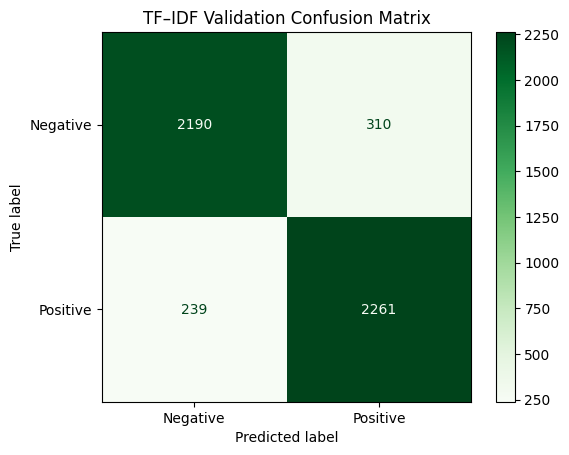


--- Test Report (TF–IDF) ---
Accuracy: 0.8905
Classification Report:
               precision    recall  f1-score   support

           0     0.8946    0.8853    0.8899     12500
           1     0.8865    0.8957    0.8910     12500

    accuracy                         0.8905     25000
   macro avg     0.8905    0.8905    0.8905     25000
weighted avg     0.8905    0.8905    0.8905     25000


Test Confusion Matrix:
 [[11066  1434]
 [ 1304 11196]]


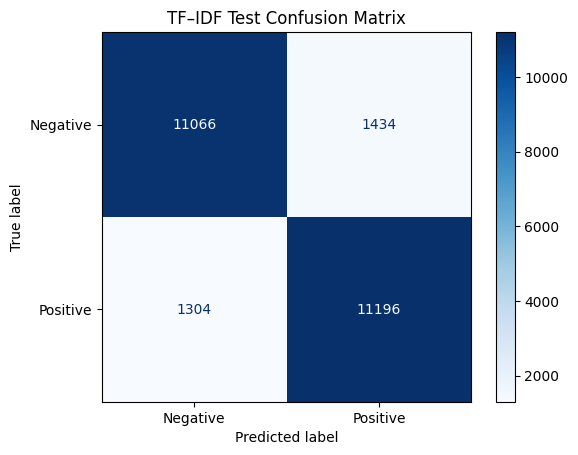

In [ ]:
# TF–IDF + Logistic Regression

print("\n=== TF–IDF + Logistic Regression ===")
start = time.time()

tfidf = TfidfVectorizer(max_features=30000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(train_df["clean_text"])
X_val_tfidf = tfidf.transform(val_df["clean_text"])
X_test_tfidf = tfidf.transform(test_data["clean_text"])

clf_tfidf = LogisticRegression(max_iter=1000)
clf_tfidf.fit(X_train_tfidf, y_train)

pred_val_tfidf = clf_tfidf.predict(X_val_tfidf)
pred_test_tfidf = clf_tfidf.predict(X_test_tfidf)
tfidf_time = time.time() - start
print("Training Time (s):", round(tfidf_time, 2))

# Validation Report
print("\n--- Validation Report (TF–IDF) ---")
print("Accuracy:", round(accuracy_score(y_val, pred_val_tfidf),4))
print("Classification Report:\n", classification_report(y_val, pred_val_tfidf, digits=4))
cm_val_tfidf = confusion_matrix(y_val, pred_val_tfidf)
print("\nValidation Confusion Matrix:\n", cm_val_tfidf)
ConfusionMatrixDisplay(confusion_matrix=cm_val_tfidf, display_labels=["Negative","Positive"]).plot(cmap=plt.cm.Greens, values_format='d')
plt.title("TF–IDF Validation Confusion Matrix")
plt.show()

# Test Report
print("\n--- Test Report (TF–IDF) ---")
print("Accuracy:", round(accuracy_score(y_test, pred_test_tfidf),4))
print("Classification Report:\n", classification_report(y_test, pred_test_tfidf, digits=4))
cm_tfidf = confusion_matrix(y_test, pred_test_tfidf)
print("\nTest Confusion Matrix:\n", cm_tfidf)
ConfusionMatrixDisplay(confusion_matrix=cm_tfidf, display_labels=["Negative","Positive"]).plot(cmap=plt.cm.Blues, values_format='d')
plt.title("TF–IDF Test Confusion Matrix")
plt.show()

# Word2Vec + Logistic Regression


=== Word2Vec + Logistic Regression ===
Training Time (s): 43.23

--- Validation Report (Word2Vec) ---
Accuracy: 0.83
Classification Report:
               precision    recall  f1-score   support

           0     0.8403    0.8148    0.8274      2500
           1     0.8203    0.8452    0.8325      2500

    accuracy                         0.8300      5000
   macro avg     0.8303    0.8300    0.8300      5000
weighted avg     0.8303    0.8300    0.8300      5000


Validation Confusion Matrix:
 [[2037  463]
 [ 387 2113]]


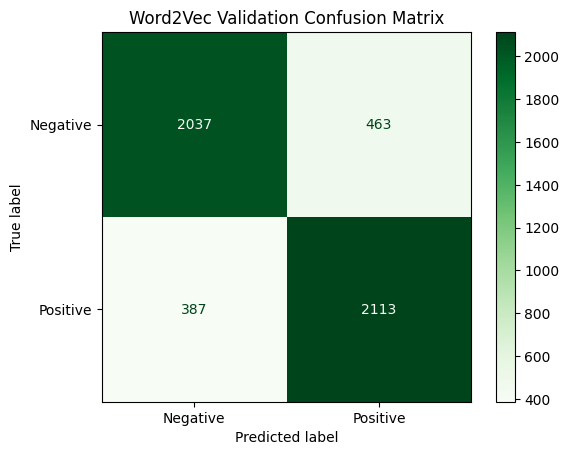


--- Test Report (Word2Vec) ---
Accuracy: 0.8299
Classification Report:
               precision    recall  f1-score   support

           0     0.8285    0.8320    0.8302     12500
           1     0.8313    0.8278    0.8295     12500

    accuracy                         0.8299     25000
   macro avg     0.8299    0.8299    0.8299     25000
weighted avg     0.8299    0.8299    0.8299     25000


Test Confusion Matrix:
 [[10400  2100]
 [ 2153 10347]]


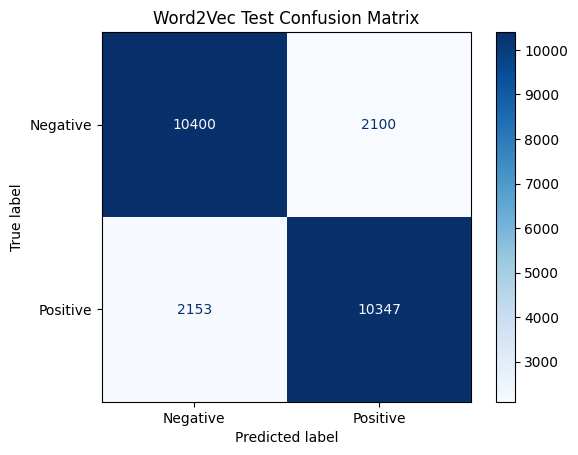

In [ ]:
# Word2Vec + Logistic Regression

print("\n=== Word2Vec + Logistic Regression ===")
start = time.time()

sentences = [t.split() for t in train_df["clean_text"]]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)

def get_w2v_vector(text):
    words = [w for w in text.split() if w in w2v_model.wv]
    if not words:
        return np.zeros(100)
    return np.mean(w2v_model.wv[words], axis=0)

X_train_w2v = np.array([get_w2v_vector(t) for t in train_df["clean_text"]])
X_val_w2v = np.array([get_w2v_vector(t) for t in val_df["clean_text"]])
X_test_w2v = np.array([get_w2v_vector(t) for t in test_data["clean_text"]])

clf_w2v = LogisticRegression(max_iter=1000)
clf_w2v.fit(X_train_w2v, y_train)

pred_val_w2v = clf_w2v.predict(X_val_w2v)
pred_test_w2v = clf_w2v.predict(X_test_w2v)
word2vec_time = time.time() - start
print("Training Time (s):", round(word2vec_time, 2))

# Validation Report
print("\n--- Validation Report (Word2Vec) ---")
print("Accuracy:", round(accuracy_score(y_val, pred_val_w2v),4))
print("Classification Report:\n", classification_report(y_val, pred_val_w2v, digits=4))
cm_val_w2v = confusion_matrix(y_val, pred_val_w2v)
print("\nValidation Confusion Matrix:\n", cm_val_w2v)
ConfusionMatrixDisplay(confusion_matrix=cm_val_w2v, display_labels=["Negative","Positive"]).plot(cmap=plt.cm.Greens, values_format='d')
plt.title("Word2Vec Validation Confusion Matrix")
plt.show()

# Test Report
print("\n--- Test Report (Word2Vec) ---")
print("Accuracy:", round(accuracy_score(y_test, pred_test_w2v),4))
print("Classification Report:\n", classification_report(y_test, pred_test_w2v, digits=4))
cm_w2v = confusion_matrix(y_test, pred_test_w2v)
print("\nTest Confusion Matrix:\n", cm_w2v)
ConfusionMatrixDisplay(confusion_matrix=cm_w2v, display_labels=["Negative","Positive"]).plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Word2Vec Test Confusion Matrix")
plt.show()

# BERT Embedding + Logistic Regression


=== BERT Embedding + Logistic Regression ===


Encoding Batches: 100%|██████████| 250/250 [06:47<00:00,  1.63s/it]



Training Time (s): 948.31

--- Validation Report (BERT) ---
              precision    recall  f1-score   support

           0     0.7980    0.8060    0.8020      1005
           1     0.8020    0.7940    0.7980       995

    accuracy                         0.8000      2000
   macro avg     0.8000    0.8000    0.8000      2000
weighted avg     0.8000    0.8000    0.8000      2000


Validation Confusion Matrix:
 [[810 195]
 [205 790]]


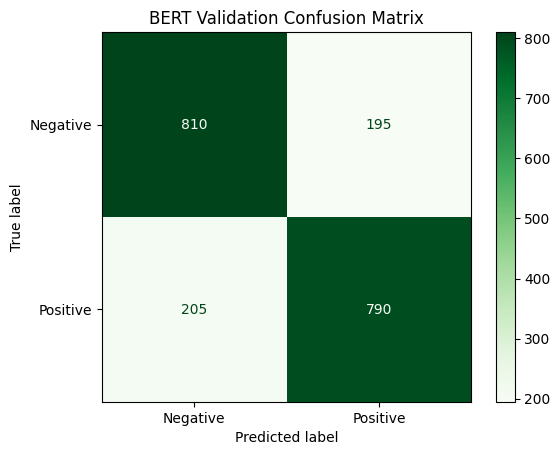


--- Test Report (BERT) ---
              precision    recall  f1-score   support

           0     0.8188    0.8375    0.8280      4056
           1     0.8289    0.8093    0.8190      3944

    accuracy                         0.8236      8000
   macro avg     0.8238    0.8234    0.8235      8000
weighted avg     0.8237    0.8236    0.8236      8000


Test Confusion Matrix:
 [[3397  659]
 [ 752 3192]]


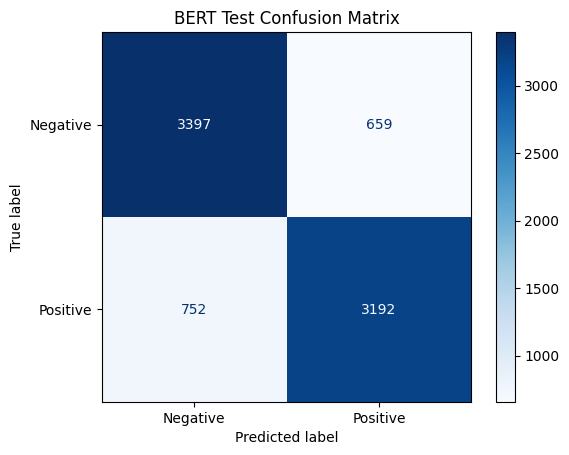

In [ ]:
# BERT Embedding + Logistic Regression
from tqdm import tqdm

print("\n=== BERT Embedding + Logistic Regression ===")
start = time.time()

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
bert_model = DistilBertModel.from_pretrained("distilbert-base-uncased")

# Function to batch-encode texts with progress bar
def get_embeddings_batch(texts, batch_size=32):
    all_embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Encoding Batches"):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", truncation=True, padding=True, max_length=128)
        with torch.no_grad():
            outputs = bert_model(**{k: v for k, v in inputs.items() if k != "token_type_ids"})
        batch_embeddings = outputs.last_hidden_state[:, 0, :].numpy()
        all_embeddings.extend(batch_embeddings)
    return np.array(all_embeddings)

# For Colab runtime efficiency: using subsets (8k train, 2k val, 8k test)
train_subset = train_df.sample(8000, random_state=1)
val_subset = val_df.sample(2000, random_state=1)
test_subset = test_data.sample(8000, random_state=1)

# Encode text data
X_train_bert = get_embeddings_batch(list(train_subset["clean_text"]), batch_size=32)
X_val_bert = get_embeddings_batch(list(val_subset["clean_text"]), batch_size=32)
X_test_bert = get_embeddings_batch(list(test_subset["clean_text"]), batch_size=32)

y_train_bert = train_subset["label"].values
y_val_bert = val_subset["label"].values
y_test_bert = test_subset["label"].values

# Train Logistic Regression
clf_bert = LogisticRegression(max_iter=500)
clf_bert.fit(X_train_bert, y_train_bert)

pred_val_bert = clf_bert.predict(X_val_bert)
pred_test_bert = clf_bert.predict(X_test_bert)
bert_time = time.time() - start
print("\nTraining Time (s):", round(bert_time, 2))

# Validation Report
print("\n--- Validation Report (BERT) ---")
print(classification_report(y_val_bert, pred_val_bert, digits=4))
cm_val_bert = confusion_matrix(y_val_bert, pred_val_bert)
print("\nValidation Confusion Matrix:\n", cm_val_bert)
ConfusionMatrixDisplay(confusion_matrix=cm_val_bert, display_labels=["Negative","Positive"]).plot(cmap=plt.cm.Greens, values_format='d')
plt.title("BERT Validation Confusion Matrix")
plt.show()

# Test Report
print("\n--- Test Report (BERT) ---")
print(classification_report(y_test_bert, pred_test_bert, digits=4))
cm_test_bert = confusion_matrix(y_test_bert, pred_test_bert)
print("\nTest Confusion Matrix:\n", cm_test_bert)
ConfusionMatrixDisplay(confusion_matrix=cm_test_bert, display_labels=["Negative","Positive"]).plot(cmap=plt.cm.Blues, values_format='d')
plt.title("BERT Test Confusion Matrix")
plt.show()

# Result Comparison

In [ ]:
# Function to compute metrics
def compute_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return round(acc, 4), round(prec, 4), round(rec, 4), round(f1, 4)

# Prepare comparison table
methods = ["TF–IDF", "Word2Vec", "BERT Embedding"]
preds_val = [pred_val_tfidf, pred_val_w2v, pred_val_bert]
preds_test = [pred_test_tfidf, pred_test_w2v, pred_test_bert]
times = [tfidf_time, word2vec_time, bert_time]

# True labels must match subset used for each model
true_val_labels = [y_val, y_val, y_val_bert]   # last one uses BERT subset
true_test_labels = [y_test, y_test, y_test_bert]

results = []
for i in range(3):
    acc_val, prec_val, rec_val, f1_val = compute_metrics(true_val_labels[i], preds_val[i])
    acc_test, prec_test, rec_test, f1_test = compute_metrics(true_test_labels[i], preds_test[i])
    results.append({
        "Method": methods[i],
        "Val_Accuracy": acc_val,
        "Val_Precision": prec_val,
        "Val_Recall": rec_val,
        "Val_F1": f1_val,
        "Test_Accuracy": acc_test,
        "Test_Precision": prec_test,
        "Test_Recall": rec_test,
        "Test_F1": f1_test,
        "Training_Time_s": round(times[i],2)
    })

# Display results
results_df = pd.DataFrame(results)
print("\n=== Final Comparison Table ===")

results_df


=== Final Comparison Table ===


,Method,Val_Accuracy,Val_Precision,Val_Recall,Val_F1,Test_Accuracy,Test_Precision,Test_Recall,Test_F1,Training_Time_s
0,TF–IDF,0.8902,0.8794,0.9044,0.8917,0.8905,0.8865,0.8957,0.8910,22.17
1,Word2Vec,0.8300,0.8203,0.8452,0.8325,0.8299,0.8313,0.8278,0.8295,43.23
2,BERT Embedding,0.8000,0.8020,0.7940,0.7980,0.8236,0.8289,0.8093,0.8190,948.31


## Analysis of Sentiment Classification Approaches

* **Best Performing Model:** The **TF–IDF + Logistic Regression** model achieved the highest overall accuracy (0.8905) and F1-score, outperforming both Word2Vec and BERT embedding approaches.

* **Reason for TF–IDF's Success:** TF–IDF effectively captured the most informative words and their relative importance within reviews, which helped the model distinguish between positive and negative sentiments with high precision.

* **Word2Vec Performance:** Word2Vec achieved moderate results (around 0.83 accuracy). While it represents semantic relationships between words, simple averaging of embeddings can lose contextual information at the sentence level, reducing classification precision.

* **BERT Embedding Behavior:** BERT showed lower accuracy (around 0.82) primarily because only pre-trained embeddings were used. Without fine-tuning, BERT’s contextual understanding was not fully utilized for this specific sentiment task.

* **Trade-offs in Accuracy and Training Time:** TF–IDF provided the best balance between performance and efficiency with a training time of ~22 seconds. Word2Vec required ~43 seconds, while BERT took ~948 seconds, showing that higher complexity does not always guarantee better results.

* **Resource Utilization:** TF–IDF is lightweight and runs efficiently on standard hardware. Word2Vec has moderate resource demands, whereas BERT is the most resource-intensive due to the embedding generation process.

* **Accuracy vs. Complexity:** TF–IDF performed strongly despite its simplicity, proving that traditional text representations can still outperform more complex models when fine-tuning is not applied.

* **Model Balance:** All three models demonstrated balanced performance between positive and negative classes, indicating that no major sentiment bias was present in classification results.

* **Common Error Patterns:** Most misclassifications occurred in reviews with sarcasm, mixed or neutral tones, where models struggled to determine a clear sentiment polarity.

* **Summary:** TF–IDF emerged as the most practical and effective approach in this experiment, offering high accuracy, low computation time, and strong generalization, making it a reliable choice for sentiment analysis tasks.